In [2]:
import numpy as np
import math
import heapq

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import matplotlib.pyplot as plt
from a_star import maze_plot
import pickle
from shapely.geometry import Polygon
from shapely.geometry import Point
from magic import ordinator


with open(r"SLAM20240124_101335.pickle", "rb") as input_file:
    e = pickle.load(input_file)

positions = e['positions']
ids = e['ids']

In [3]:
positions_array = np.array(positions)
positions_array = np.array(positions)

mask_external = (ids % 3 == 2) & (ids >= 100) & (ids <= 1000)
mask_internal = (ids % 3 == 0) & (ids >= 100) & (ids <= 1000)

ids_external = ids[mask_external]
ids_internal = ids[mask_internal]

positions_external = positions_array[mask_external]
positions_internal = positions_array[mask_internal]


pos_list_ext = [pos for pos in positions_external]
pos_list_int = [pos for pos in positions_internal]

external_ordered = np.array(ordinator(pos_list_ext,max_distance=0.6))
internal_ordered = np.array(ordinator(pos_list_int))

spatial_step=0.03
max_x=np.max(external_ordered[:,0])
max_y=np.max(external_ordered[:,1])
min_x=np.min(external_ordered[:,0])
min_y=np.min(external_ordered[:,1])
delta_x=max_x-min_x
delta_y=max_y-min_y
center_x=min_x+delta_x/2
center_y=min_y+delta_y/2

n_x = int(delta_x/spatial_step/1.5)
n_y = int(delta_y/spatial_step/1.5)

ext_ordered_poly = Polygon(external_ordered)
int_ordered_poly = Polygon(internal_ordered)

x = np.linspace(min(np.concatenate([external_ordered[:, 0], internal_ordered[:, 0]])), max(
    np.concatenate([external_ordered[:, 0], internal_ordered[:, 0]])), n_x)
y = np.linspace(min(np.concatenate([external_ordered[:, 1], internal_ordered[:, 1]])), max(
    np.concatenate([external_ordered[:, 1], internal_ordered[:, 1]])), n_y)
X, Y = np.meshgrid(x, y)

# Create a mask where the pixels inside the first circle and outside the second circle are set to 1, and all others are set to 0
mask = np.array([[ext_ordered_poly.contains(Point(x[i], y[j])) and not int_ordered_poly.contains(
    Point(x[i], y[j])) for i in range(len(x))] for j in range(len(y))])

Missing 2 nodes to close the polygon; min_dist = 2.5830176518299472
Missing 1 nodes to close the polygon; min_dist = 0.70293141703667


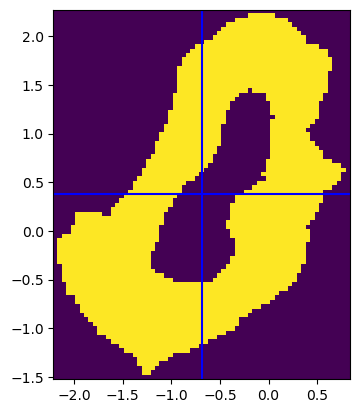

(84, 67)

In [4]:
plt.imshow(mask, interpolation='nearest', origin='upper',
           extent=[min(x), max(x), min(y), max(y)])
plt.axhline(center_y, color='blue')
plt.axvline(center_x, color='blue')
# plt.scatter(min_x, center_y, color='green')
# plt.scatter(0.5, 0, color='red',)
# plt.scatter(center_x, center_y, color='blue')
plt.show()
mask.shape

# Beginning of heuristic

In [30]:
def distance(a,b):
    return np.sqrt((a[0]-b[0])**2+ (a[1]-b[1])**2)


def angle_between_three_points(pointA, pointB, pointC):
    '''Returns the angle (in degrees) between vectors AC and AB'''


    # Check if pointA and pointC are the same
    if np.all(pointA == pointC):
        return 0

    # Calculate vectors AB and AC
    AB = np.subtract(pointA, pointB)
    AC = np.subtract(pointA, pointC)

    # Check if AB or AC is a zero vector
    if np.linalg.norm(AB) == 0 or np.linalg.norm(AC) == 0:
        raise ValueError("One of the input points is identical to the other.")

    # Normalize the vectors
    AB_normalized = AB / np.linalg.norm(AB)
    AC_normalized = AC / np.linalg.norm(AC)

    # Calculate the dot product
    dot_product = np.dot(AB_normalized, AC_normalized)

    # Calculate the angle in radians
    angle_radians = np.arccos(np.clip(dot_product, -1.0, 1.0))

    # Convert the angle to degrees and ensure it's between 0 and 360
    angle_degrees = np.degrees(angle_radians) % 360

    return angle_degrees


def heuristic_(maze, current, start):
    total_distance = 0
    row, col =maze.shape[0]-1, maze.shape[1]-1
    max_row = 0
    min_row = 0
    max_col = 0
    min_col = 0

    # print("Rows:",row,"Cols:", col)

    # Finding max and min row
    for i in range(row):
        if (maze[i,:]==0).any():
            max_row= i
            break
    for i in range(row,0,-1):
        if (maze[i,:]==0).any():
            min_row = i
            break

    # Finding max and min col
    for i in range(col):
        if (maze[:,i]==0).any():
            max_col= i
            break
    for i in range(col,0,-1):
        if (maze[:,i]==0).any():
            min_col = i
            break

    # print("Max and min rows",max_row, min_row)
    # print("Max and min cols",max_col, min_col)

    # Find center of the circle    
    center_row, center_col = max_row+int((min_row-max_row)/2), max_col+int((min_col-max_col)/2)
    center = [center_row, center_col]

    # print("Center row:",center_row)
    # print("Center col:", center_col)

    radius = max(center_row, center_col)
    # print("Radius:",radius)

    # distance between center and starting point
    dist_center_start = distance(center, start)
    dist_start_circle = radius-dist_center_start

    # distance between center and current
    dist_center_current = distance(center, current)
    dist_current_circle = radius-dist_center_current

    # angle
    ########################## ERROR SOMEWHERE HERE
    # angle = angle_between_three_points(current, center, start)  # returns angle between AB and AC
    # print("Angle:", angle)

    # arc: 2*pi*r = theta : 360
    # arc = (angle*2*math.pi*radius)/360
    circumference = 2*math.pi*radius


    # total_distance = dist_current_circle + 2*r*pi-arc + dist_start_circle
    total_distance = dist_start_circle + dist_current_circle + circumference #- arc


    # return center_row, center_col, radius, total_distance
    return total_distance

def astar(maze, start, end):
    moves = [(0, 1), (0, -1), (1, 0), (-1, 0),
             (1, 1), (-1, -1), (-1, 1), (1, -1)]
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic_(maze, start, end)}
    oheap = []

    def neighbors_available(position, maze, moves):
        neighbors = []
        for move in moves:
            x_test = position[0]+move[0]
            y_test = position[1]+move[1]
            maze_test = maze[x_test, y_test]
            if x_test >= 0 and x_test < maze.shape[0]-1:
                if y_test >= 0 and y_test < maze.shape[1]-1:
                    if maze_test != 1:
                        neighbors.append((x_test, y_test))

        return neighbors

    heapq.heappush(oheap, (fscore[start], start))

    while oheap:
        current = heapq.heappop(oheap)[1]

        if current == end:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for neighbor in neighbors_available(current, maze, moves):
            tentative_g_score = gscore[current] + 1

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue

            if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic_(maze, neighbor, end)
                heapq.heappush(oheap, (fscore[neighbor], neighbor))

    return False

def maze_plot(maze, start, end):
    path = astar(maze, start[::-1], end[::-1]) # Invert x and y for map
    path.append(start[::-1])
    plt.imshow(maze, origin='upper')

    for i in path:
        plt.scatter(i[1], i[0], color='red')
    plt.show()
    
    path = [(x[1],x[0]) for x in path]
    print(path[::-1])

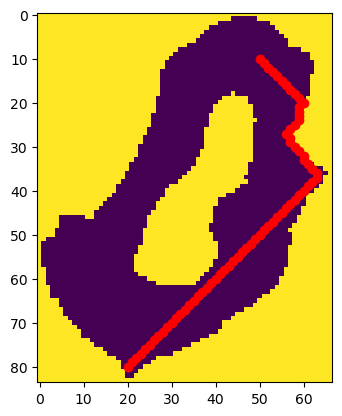

[(20, 80), (21, 79), (22, 78), (23, 77), (24, 76), (25, 75), (26, 74), (27, 73), (28, 72), (29, 71), (30, 70), (31, 69), (32, 68), (33, 67), (34, 66), (35, 65), (36, 64), (37, 63), (38, 62), (39, 61), (40, 60), (41, 59), (42, 58), (43, 57), (44, 56), (45, 55), (46, 54), (47, 53), (48, 52), (49, 51), (50, 50), (51, 49), (52, 48), (53, 47), (54, 46), (55, 45), (56, 44), (57, 43), (58, 42), (59, 41), (60, 40), (61, 39), (62, 38), (63, 37), (63, 36), (62, 35), (61, 34), (60, 33), (60, 32), (59, 31), (58, 30), (57, 29), (57, 28), (56, 27), (57, 26), (58, 25), (59, 24), (59, 23), (59, 22), (59, 21), (60, 20), (59, 19), (58, 18), (57, 17), (56, 16), (55, 15), (54, 14), (53, 13), (52, 12), (51, 11), (50, 10)]


In [40]:
mask = 1-mask

# start = (40,10)
start = (20, 80)
end = (50, 10)
# point = (20,70)

maze_plot(mask, start, end)
# plt.scatter([point[0]], [point[1]])

# Angle between three points



In [10]:
def angle_between_three_points(pointA, pointB, pointC):
    '''Returns the angle (in degrees) between vectors AB and AC'''


    # Check if pointA and pointC are the same
    if np.all(pointA == pointC):
        return 0

    # Calculate vectors AB and AC
    AB = np.subtract(pointA, pointB)
    AC = np.subtract(pointA, pointC)

    # Check if AB or AC is a zero vector
    if np.linalg.norm(AB) == 0 or np.linalg.norm(AC) == 0:
        raise ValueError("One of the input points is identical to the other.")

    # Normalize the vectors
    AB_normalized = AB / np.linalg.norm(AB)
    AC_normalized = AC / np.linalg.norm(AC)

    # Calculate the dot product
    dot_product = np.dot(AB_normalized, AC_normalized)

    # Calculate the angle in radians
    angle_radians = np.arccos(np.clip(dot_product, -1.0, 1.0))

    # Convert the angle to degrees and ensure it's between 0 and 360
    angle_degrees = np.degrees(angle_radians) % 360

    return angle_degrees


A = np.array([0,-1])
B = np.array([0,0])
C = np.array([1,0])

print(angle_between_three_points(A,C,B))

45.00000000000001


# End of angle

In [8]:


# maze_plot(maze, start, end)
crow, ccol, radius, total_distance = heuristic_(mask, start, end)
center = [crow, ccol]

TypeError: cannot unpack non-iterable numpy.float64 object

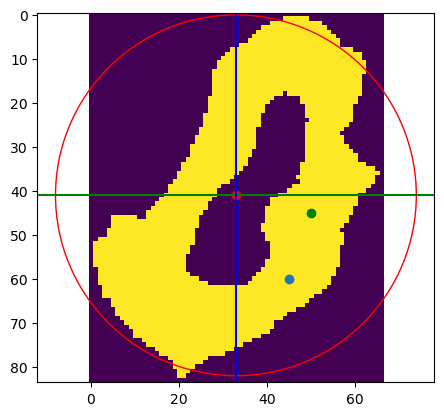

Perimeter: 257.610597594363


In [ ]:
# NB invert row and cols when plotting!!

plt.imshow(mask, interpolation='nearest', origin='upper')
plt.axhline(crow, color='green')
plt.axvline(ccol, color='blue')

plt.scatter(ccol, crow, color='red')
plt.scatter(start[1], start[0]) # col, row
plt.scatter(50,45, color='green')
# Add a circle
circle = Circle((ccol, crow), radius=radius, color='red', fill=False)
plt.gca().add_patch(circle)

plt.show()

print("Perimeter:",np.pi*2*radius)

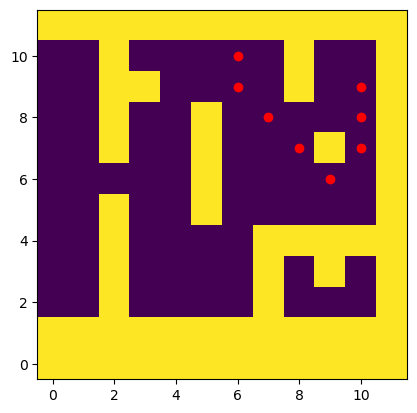

[(6, 10), (6, 9), (7, 8), (8, 7), (9, 6), (10, 7), (10, 8), (10, 9)]


In [ ]:
maze = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
                [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1],
                [0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1],
                [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
                [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
                [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1],
                [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
                [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1],
                [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

start = (6, 10)
end = (10, 9)


maze_plot(maze, start, end)    

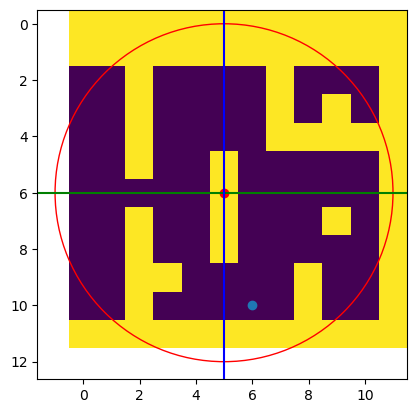

Perimeter: 37.69911184307752


In [ ]:
# NB invert row and cols when plotting!!

plt.imshow(maze, interpolation='nearest', origin='upper')
plt.axhline(crow, color='green')
plt.axvline(ccol, color='blue')

plt.scatter(ccol, crow, color='red')
plt.scatter(6,10)
# Add a circle
circle = Circle((ccol, crow), radius=radius, color='red', fill=False)
plt.gca().add_patch(circle)

plt.show()

print("Perimeter:",np.pi*2*radius)